# Fully Convolutional Networks for Semantic Segmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
import os
from pathlib import Path
import cv2
import random
from torchmetrics.segmentation import MeanIoU
from tqdm import tqdm
import wandb

## Dataset Visualization

In [2]:
# read train and test folders
dataset_path = Path("dataset")
train_images_path = dataset_path / "train" / "images"
train_labels_path = dataset_path / "train" / "labels"
test_images_path = dataset_path / "test" / "images"
test_labels_path = dataset_path / "test" / "labels"

train_file_names = os.listdir(train_images_path)
test_file_names = os.listdir(test_images_path)

# create validation split
val_file_names = train_file_names[:500]
train_file_names = train_file_names[500:]
print(f"Number of training samples: {len(train_file_names)}")
print(f"Number of validation samples: {len(val_file_names)}")
print(f"Number of test samples: {len(test_file_names)}")

Number of training samples: 1500
Number of validation samples: 500
Number of test samples: 500


In [3]:
labels_map = {
    0:"Unlabeled",
    1: "Building",
    2: "Fence",
    3: "Other",
    4: "Pedestrian",
    5: "Pole",
    6: "RoadLine",
    7: "Road",
    8: "Sidewalk",
    9: "Vegetation",
    10: "Vegetation",
    11: "Car",
    12: "Wall",
    13: "Traffic Sign",
}

In [4]:
# function to show an image with the ground truth masks
def plot_image_with_gt_masks(image_path, label_path):
    image = cv2.imread(image_path)
    label = cv2.imread(label_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)[:,:,0]
    fig, axs = plt.subplots(3, 5, figsize=(20, 10))
    axs = axs.flatten()
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis('off')
    axs[1].imshow(label)
    axs[1].set_title("Label")
    axs[1].axis('off')

    for i in range(0, 13):
        axs[i+2].imshow(label == i)
        axs[i+2].set_title(labels_map[i])
        axs[i+2].axis('off')
        
    plt.suptitle("Image with Ground Truth Masks")
    plt.tight_layout()
    plt.show()

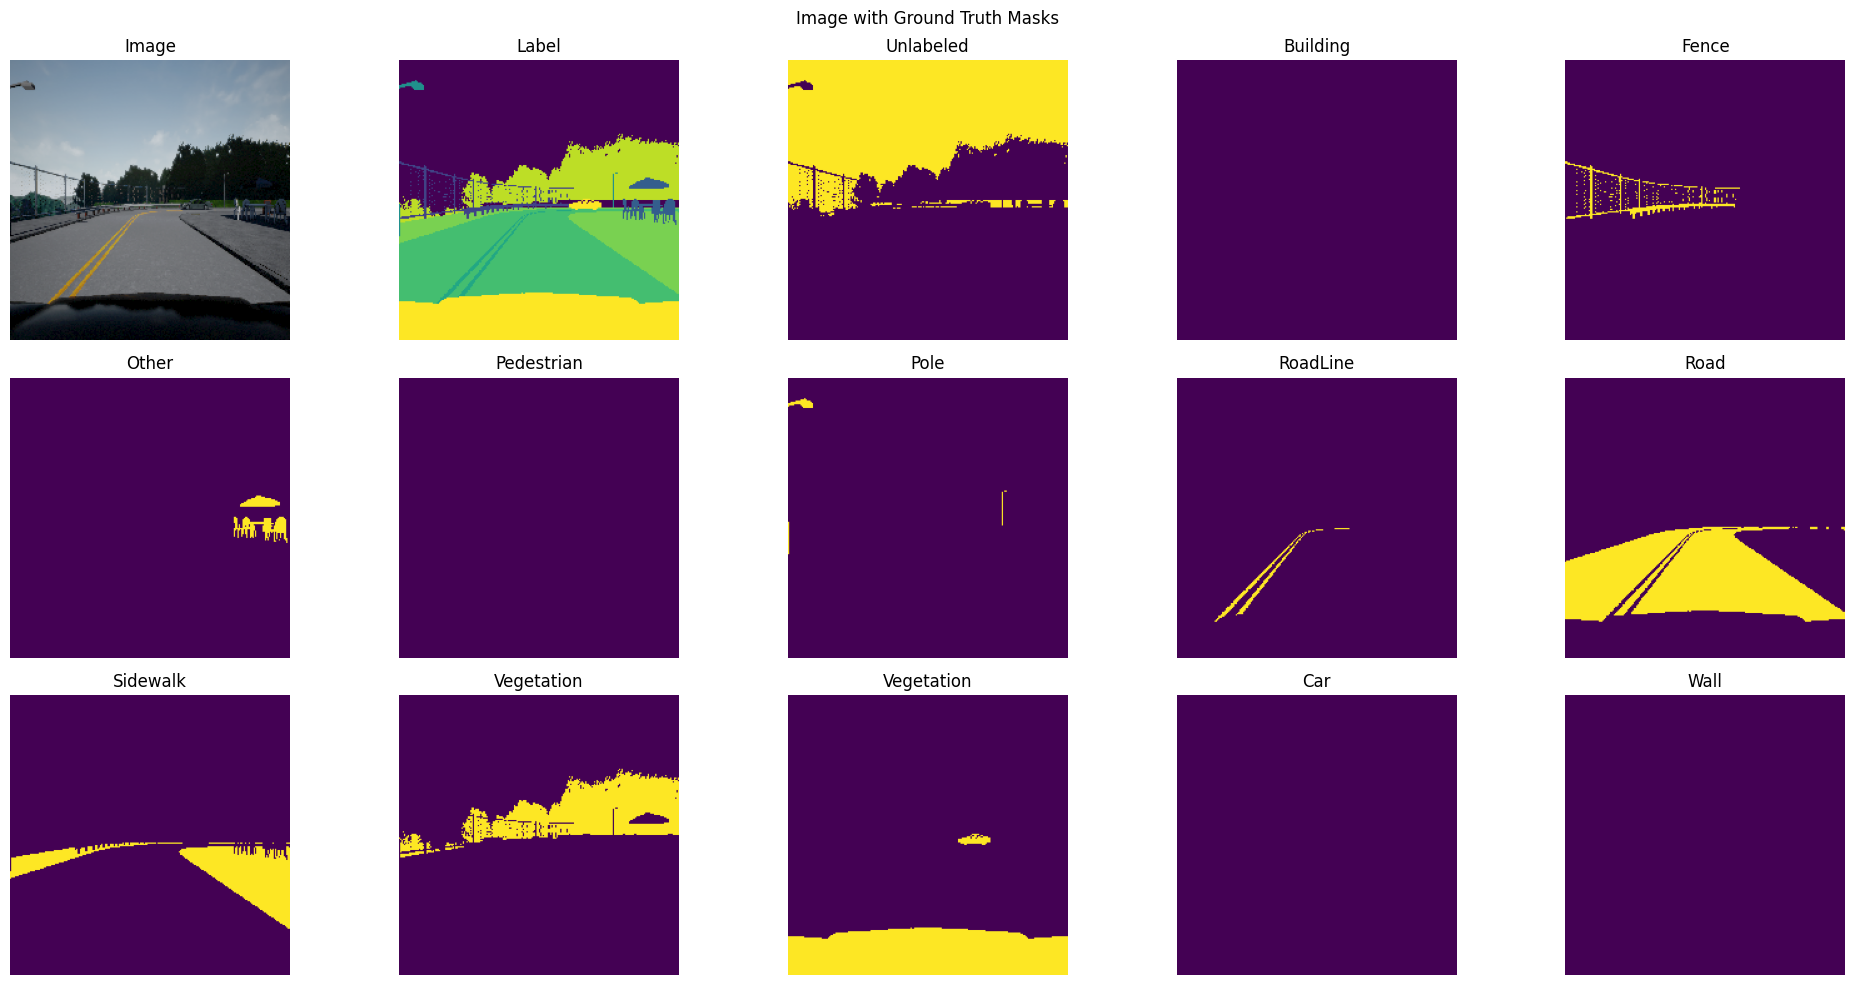

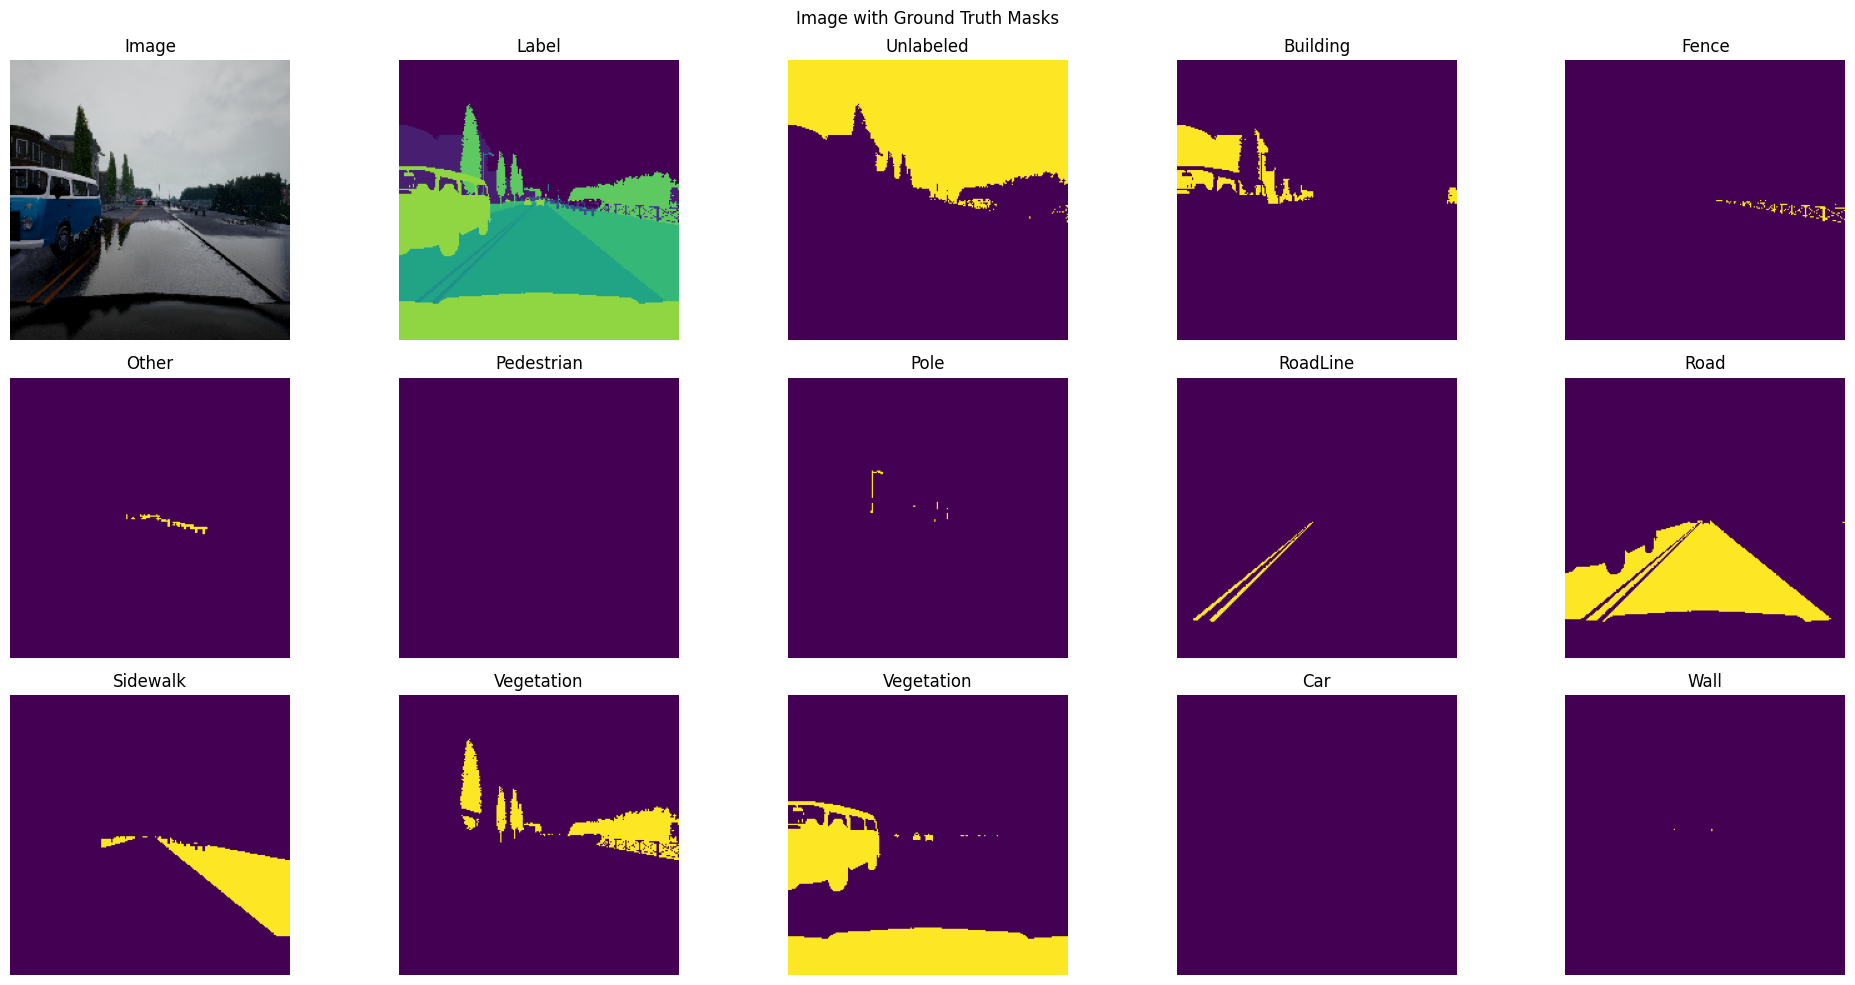

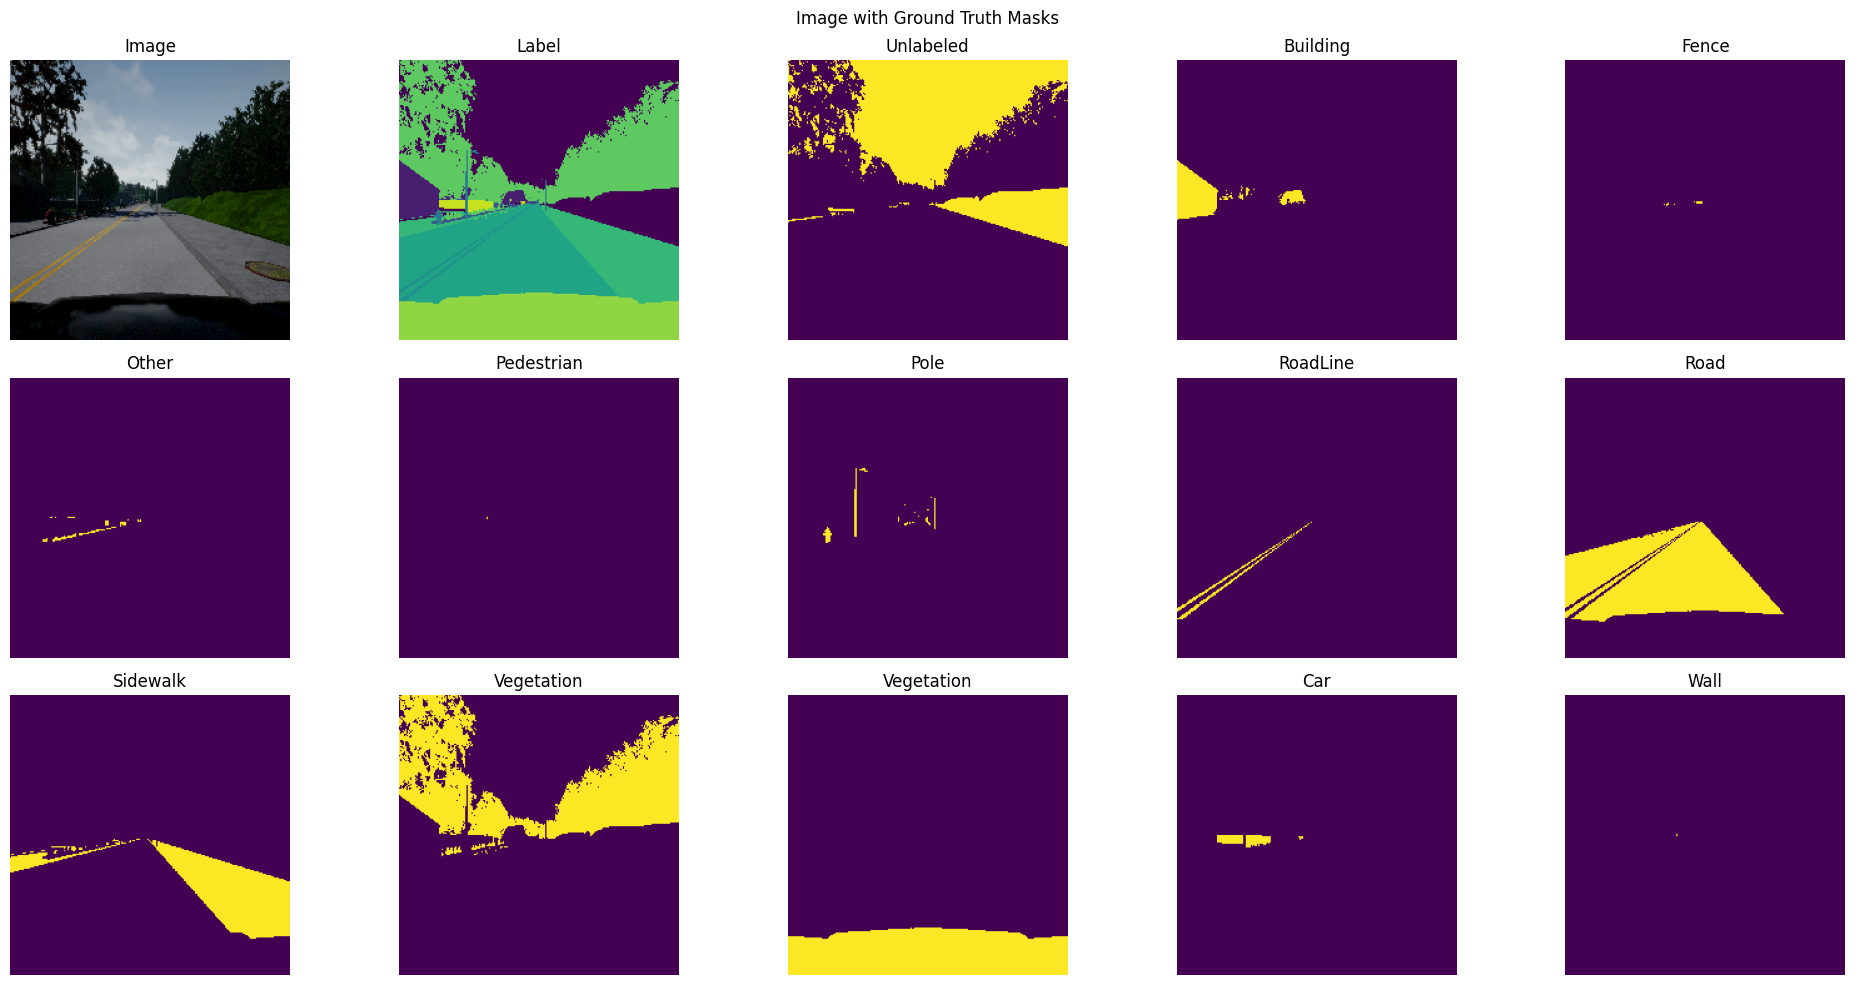

In [5]:
# show random 3 images with ground truth masks
for _ in range(3):
    random_index = random.randint(0, len(train_file_names)-1)
    image_path = train_images_path / train_file_names[random_index]
    label_path = train_labels_path / train_file_names[random_index]
    plot_image_with_gt_masks(image_path, label_path)

In [6]:
# create dataset class
class ImageDataset(Dataset):
    def __init__(self, images_path, labels_path, file_names):
        self.images_path = images_path
        self.labels_path = labels_path
        self.file_names = file_names

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_path, self.file_names[idx])
        label_name = os.path.join(self.labels_path, self.file_names[idx])

        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = torch.from_numpy(image).permute(2, 0, 1) / 255.0
        label = cv2.imread(label_name)[:,:,2]
        label = torch.from_numpy(label).long()
        # label = F.one_hot(label, num_classes=13).permute(2, 0, 1)
        # label = label.float()

        return image, label
    
train_dataset = ImageDataset(train_images_path, train_labels_path, train_file_names)
val_dataset = ImageDataset(train_images_path, train_labels_path, val_file_names)
test_dataset = ImageDataset(test_images_path, test_labels_path, test_file_names)

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# see vgg16 layer names
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
for name, layer in vgg16.named_children():
    print(name, layer)

features Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, 

In [8]:
# print shape after each maxpooling layer
def print_shapes(model, x):
    for name, layer in model.named_children():
        x = layer(x)
        if isinstance(layer, nn.MaxPool2d):
            print(name, x.shape)
x = torch.randn(1, 3, 224, 224)
print_shapes(vgg16.features, x)

4 torch.Size([1, 64, 112, 112])
9 torch.Size([1, 128, 56, 56])
16 torch.Size([1, 256, 28, 28])
23 torch.Size([1, 512, 14, 14])
30 torch.Size([1, 512, 7, 7])


## FCN Variants

In [9]:
class FCN32s(nn.Module):
    def __init__(self, num_classes=13, update_weights=False):
        super(FCN32s, self).__init__()
        self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        for param in self.vgg.parameters():
            param.requires_grad = update_weights
            
        self.score_pool5 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upsample_final = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, padding=16, bias=False)
        
    def forward(self, x):
        x = self.vgg(x)
        x = self.score_pool5(x)
        x = self.upsample_final(x)
        return x
    
class FCN16s(nn.Module):
    def __init__(self, num_classes=13, update_weights=False):
        super(FCN16s, self).__init__()
        self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        for param in self.vgg.parameters():
            param.requires_grad = update_weights
            
        # after pool4
        self.pool4 = nn.Sequential(*self.vgg[:24])
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.pool5 = nn.Sequential(*self.vgg[24:])
        self.score_pool5 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upsample_pool5 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.upsample_final = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, padding=8, bias=False)
    
    def forward(self, x):
        pool4 = self.pool4(x)
        x = self.pool5(pool4)
        x = self.score_pool5(x)
        x = self.upsample_pool5(x)
        pool4 = self.score_pool4(pool4)
        x = x + pool4
        x = self.upsample_final(x)
        return x

class FCN8s(nn.Module):
    def __init__(self, num_classes=13, update_weights=False):
        super(FCN8s, self).__init__()
        self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        for param in self.vgg.parameters():
            param.requires_grad = update_weights
            
        # after pool3
        self.pool3 = nn.Sequential(*self.vgg[:17])
        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.pool4 = nn.Sequential(*self.vgg[17:24])
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.pool5 = nn.Sequential(*self.vgg[24:])
        self.score_pool5 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upsample_pool5 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.upsample_pool4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.upsample_final = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4, bias=False)
        
    def forward(self, x):
        x = self.pool3(x)
        pool3 = self.score_pool3(x)
        x = self.pool4(x)
        pool4 = self.score_pool4(x)
        x = self.pool5(x)
        x = self.score_pool5(x)
        x = self.upsample_pool5(x)
        x = x + pool4
        x = self.upsample_pool4(x)
        x = x + pool3
        x = self.upsample_final(x)
        return x

### Training

In [10]:
# training loop
log_wandb = False
def train_model(model, train_loader, val_loader, epochs, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    metric = MeanIoU(num_classes=13).to(device)
    
    for epoch in range(epochs):
        model.train()
        metric.reset()
        train_loss = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            
            metric.update(preds, labels)
        
        train_loss /= len(train_loader)
        train_iou = metric.compute().item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, IoU: {train_iou:.4f}")
        if log_wandb:
            wandb.log({"train_loss": train_loss, "train_iou": train_iou})
        # validation
        model.eval()
        metric.reset()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1)
                metric.update(preds, labels)
        val_loss /= len(val_loader)
        val_iou = metric.compute().item()
        print(f"Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}")
        if log_wandb:
            wandb.log({"val_loss": val_loss, "val_iou": val_iou})

In [11]:
# train all models
fcn_models = {
    "FCN32s_frozen": FCN32s(num_classes=13, update_weights=False),
    "FCN16s_frozen": FCN16s(num_classes=13, update_weights=False),
    "FCN8s_frozen": FCN8s(num_classes=13, update_weights=False),
    "FCN32s_trainable": FCN32s(num_classes=13, update_weights=True),
    "FCN16s_trainable": FCN16s(num_classes=13, update_weights=True),
    "FCN8s_trainable": FCN8s(num_classes=13, update_weights=True),
}

In [12]:
# wandb logging
log_wandb = True
for name, model in fcn_models.items():
    print(f"Training {name}...")
    wandb.init(project="fcn_segmentation", name=name, config={"model": name})
    train_model(model, train_loader, val_loader, epochs=20, lr=0.001)
    wandb.finish()

Training FCN32s_frozen...


wandb: Currently logged in as: gauravbehera (gauravbehera-iiith) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 47/47 [00:04<00:00,  9.64it/s]


Epoch 1/20, Loss: 1.8493, IoU: 0.2709
Validation Loss: 1.2420, IoU: 0.3973


100%|██████████| 47/47 [00:04<00:00, 10.23it/s]


Epoch 2/20, Loss: 0.9392, IoU: 0.4686
Validation Loss: 0.7455, IoU: 0.5287


100%|██████████| 47/47 [00:04<00:00, 10.22it/s]


Epoch 3/20, Loss: 0.6719, IoU: 0.5581
Validation Loss: 0.6141, IoU: 0.5969


100%|██████████| 47/47 [00:04<00:00, 10.22it/s]


Epoch 4/20, Loss: 0.5811, IoU: 0.5990
Validation Loss: 0.5534, IoU: 0.6185


100%|██████████| 47/47 [00:04<00:00, 10.20it/s]


Epoch 5/20, Loss: 0.5330, IoU: 0.6204
Validation Loss: 0.5180, IoU: 0.6320


100%|██████████| 47/47 [00:04<00:00, 10.19it/s]


Epoch 6/20, Loss: 0.5025, IoU: 0.6330
Validation Loss: 0.4939, IoU: 0.6401


100%|██████████| 47/47 [00:04<00:00, 10.19it/s]


Epoch 7/20, Loss: 0.4811, IoU: 0.6414
Validation Loss: 0.4768, IoU: 0.6502


100%|██████████| 47/47 [00:04<00:00, 10.17it/s]


Epoch 8/20, Loss: 0.4653, IoU: 0.6474
Validation Loss: 0.4635, IoU: 0.6553


100%|██████████| 47/47 [00:04<00:00, 10.14it/s]


Epoch 9/20, Loss: 0.4526, IoU: 0.6529
Validation Loss: 0.4536, IoU: 0.6625


100%|██████████| 47/47 [00:04<00:00, 10.22it/s]


Epoch 10/20, Loss: 0.4420, IoU: 0.6567
Validation Loss: 0.4444, IoU: 0.6606


100%|██████████| 47/47 [00:04<00:00, 10.12it/s]


Epoch 11/20, Loss: 0.4334, IoU: 0.6603
Validation Loss: 0.4374, IoU: 0.6640


100%|██████████| 47/47 [00:04<00:00, 10.16it/s]


Epoch 12/20, Loss: 0.4255, IoU: 0.6627
Validation Loss: 0.4309, IoU: 0.6674


100%|██████████| 47/47 [00:04<00:00, 10.15it/s]


Epoch 13/20, Loss: 0.4193, IoU: 0.6654
Validation Loss: 0.4267, IoU: 0.6678


100%|██████████| 47/47 [00:04<00:00, 10.23it/s]


Epoch 14/20, Loss: 0.4137, IoU: 0.6672
Validation Loss: 0.4214, IoU: 0.6743


100%|██████████| 47/47 [00:04<00:00, 10.17it/s]


Epoch 15/20, Loss: 0.4085, IoU: 0.6691
Validation Loss: 0.4170, IoU: 0.6710


100%|██████████| 47/47 [00:04<00:00, 10.18it/s]


Epoch 16/20, Loss: 0.4041, IoU: 0.6704
Validation Loss: 0.4135, IoU: 0.6720


100%|██████████| 47/47 [00:04<00:00,  9.97it/s]


Epoch 17/20, Loss: 0.3998, IoU: 0.6727
Validation Loss: 0.4103, IoU: 0.6739


100%|██████████| 47/47 [00:04<00:00, 10.17it/s]


Epoch 18/20, Loss: 0.3962, IoU: 0.6742
Validation Loss: 0.4072, IoU: 0.6755


100%|██████████| 47/47 [00:04<00:00, 10.20it/s]


Epoch 19/20, Loss: 0.3930, IoU: 0.6753
Validation Loss: 0.4046, IoU: 0.6781


100%|██████████| 47/47 [00:04<00:00, 10.18it/s]


Epoch 20/20, Loss: 0.3899, IoU: 0.6768
Validation Loss: 0.4023, IoU: 0.6781


train_iou,▁▄▆▇▇▇▇▇████████████
train_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_iou,▁▄▆▇▇▇▇▇████████████
val_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_iou,0.67684
train_loss,0.38991
val_iou,0.67809
val_loss,0.40234


Training FCN16s_frozen...


100%|██████████| 47/47 [00:04<00:00, 10.41it/s]


Epoch 1/20, Loss: 1.6327, IoU: 0.3254
Validation Loss: 0.8358, IoU: 0.5097


100%|██████████| 47/47 [00:04<00:00, 10.49it/s]


Epoch 2/20, Loss: 0.6215, IoU: 0.6118
Validation Loss: 0.5026, IoU: 0.6677


100%|██████████| 47/47 [00:04<00:00, 10.53it/s]


Epoch 3/20, Loss: 0.4587, IoU: 0.6836
Validation Loss: 0.4247, IoU: 0.6999


100%|██████████| 47/47 [00:04<00:00, 10.53it/s]


Epoch 4/20, Loss: 0.4044, IoU: 0.7031
Validation Loss: 0.3896, IoU: 0.7118


100%|██████████| 47/47 [00:04<00:00, 10.35it/s]


Epoch 5/20, Loss: 0.3753, IoU: 0.7133
Validation Loss: 0.3673, IoU: 0.7200


100%|██████████| 47/47 [00:04<00:00, 10.28it/s]


Epoch 6/20, Loss: 0.3556, IoU: 0.7198
Validation Loss: 0.3512, IoU: 0.7233


100%|██████████| 47/47 [00:04<00:00, 10.50it/s]


Epoch 7/20, Loss: 0.3409, IoU: 0.7253
Validation Loss: 0.3394, IoU: 0.7285


100%|██████████| 47/47 [00:04<00:00, 10.50it/s]


Epoch 8/20, Loss: 0.3297, IoU: 0.7292
Validation Loss: 0.3307, IoU: 0.7337


100%|██████████| 47/47 [00:04<00:00, 10.48it/s]


Epoch 9/20, Loss: 0.3207, IoU: 0.7327
Validation Loss: 0.3236, IoU: 0.7375


100%|██████████| 47/47 [00:04<00:00, 10.47it/s]


Epoch 10/20, Loss: 0.3133, IoU: 0.7355
Validation Loss: 0.3167, IoU: 0.7392


100%|██████████| 47/47 [00:04<00:00, 10.43it/s]


Epoch 11/20, Loss: 0.3072, IoU: 0.7381
Validation Loss: 0.3116, IoU: 0.7412


100%|██████████| 47/47 [00:04<00:00, 10.35it/s]


Epoch 12/20, Loss: 0.3017, IoU: 0.7402
Validation Loss: 0.3075, IoU: 0.7389


100%|██████████| 47/47 [00:04<00:00, 10.52it/s]


Epoch 13/20, Loss: 0.2972, IoU: 0.7415
Validation Loss: 0.3033, IoU: 0.7442


100%|██████████| 47/47 [00:04<00:00, 10.40it/s]


Epoch 14/20, Loss: 0.2932, IoU: 0.7434
Validation Loss: 0.3009, IoU: 0.7403


100%|██████████| 47/47 [00:04<00:00, 10.34it/s]


Epoch 15/20, Loss: 0.2900, IoU: 0.7444
Validation Loss: 0.2980, IoU: 0.7451


100%|██████████| 47/47 [00:04<00:00, 10.40it/s]


Epoch 16/20, Loss: 0.2867, IoU: 0.7460
Validation Loss: 0.2952, IoU: 0.7449


100%|██████████| 47/47 [00:04<00:00, 10.42it/s]


Epoch 17/20, Loss: 0.2837, IoU: 0.7465
Validation Loss: 0.2925, IoU: 0.7481


100%|██████████| 47/47 [00:04<00:00, 10.50it/s]


Epoch 18/20, Loss: 0.2811, IoU: 0.7479
Validation Loss: 0.2913, IoU: 0.7490


100%|██████████| 47/47 [00:04<00:00, 10.44it/s]


Epoch 19/20, Loss: 0.2790, IoU: 0.7488
Validation Loss: 0.2894, IoU: 0.7461


100%|██████████| 47/47 [00:04<00:00, 10.46it/s]


Epoch 20/20, Loss: 0.2769, IoU: 0.7494
Validation Loss: 0.2873, IoU: 0.7486


train_iou,▁▆▇▇▇███████████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_iou,▁▆▇▇▇▇▇█████████████
val_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_iou,0.74944
train_loss,0.27688
val_iou,0.74859
val_loss,0.28733


Training FCN8s_frozen...


100%|██████████| 47/47 [00:04<00:00, 10.36it/s]


Epoch 1/20, Loss: 1.5299, IoU: 0.3735
Validation Loss: 0.7105, IoU: 0.5776


100%|██████████| 47/47 [00:04<00:00, 10.49it/s]


Epoch 2/20, Loss: 0.5275, IoU: 0.6686
Validation Loss: 0.4355, IoU: 0.7141


100%|██████████| 47/47 [00:04<00:00, 10.37it/s]


Epoch 3/20, Loss: 0.3996, IoU: 0.7194
Validation Loss: 0.3736, IoU: 0.7376


100%|██████████| 47/47 [00:04<00:00, 10.46it/s]


Epoch 4/20, Loss: 0.3536, IoU: 0.7377
Validation Loss: 0.3411, IoU: 0.7474


100%|██████████| 47/47 [00:04<00:00, 10.52it/s]


Epoch 5/20, Loss: 0.3279, IoU: 0.7477
Validation Loss: 0.3213, IoU: 0.7560


100%|██████████| 47/47 [00:04<00:00, 10.57it/s]


Epoch 6/20, Loss: 0.3101, IoU: 0.7551
Validation Loss: 0.3076, IoU: 0.7597


100%|██████████| 47/47 [00:04<00:00, 10.54it/s]


Epoch 7/20, Loss: 0.2965, IoU: 0.7602
Validation Loss: 0.2961, IoU: 0.7661


100%|██████████| 47/47 [00:04<00:00, 10.29it/s]


Epoch 8/20, Loss: 0.2865, IoU: 0.7643
Validation Loss: 0.2880, IoU: 0.7687


100%|██████████| 47/47 [00:04<00:00, 10.52it/s]


Epoch 9/20, Loss: 0.2776, IoU: 0.7675
Validation Loss: 0.2802, IoU: 0.7705


100%|██████████| 47/47 [00:04<00:00, 10.57it/s]


Epoch 10/20, Loss: 0.2705, IoU: 0.7703
Validation Loss: 0.2735, IoU: 0.7720


100%|██████████| 47/47 [00:04<00:00, 10.31it/s]


Epoch 11/20, Loss: 0.2642, IoU: 0.7728
Validation Loss: 0.2688, IoU: 0.7752


100%|██████████| 47/47 [00:04<00:00, 10.59it/s]


Epoch 12/20, Loss: 0.2587, IoU: 0.7749
Validation Loss: 0.2651, IoU: 0.7769


100%|██████████| 47/47 [00:04<00:00, 10.59it/s]


Epoch 13/20, Loss: 0.2550, IoU: 0.7760
Validation Loss: 0.2602, IoU: 0.7788


100%|██████████| 47/47 [00:04<00:00, 10.45it/s]


Epoch 14/20, Loss: 0.2506, IoU: 0.7780
Validation Loss: 0.2564, IoU: 0.7783


100%|██████████| 47/47 [00:04<00:00, 10.53it/s]


Epoch 15/20, Loss: 0.2468, IoU: 0.7791
Validation Loss: 0.2547, IoU: 0.7831


100%|██████████| 47/47 [00:04<00:00, 10.53it/s]


Epoch 16/20, Loss: 0.2438, IoU: 0.7804
Validation Loss: 0.2518, IoU: 0.7821


100%|██████████| 47/47 [00:04<00:00, 10.60it/s]


Epoch 17/20, Loss: 0.2414, IoU: 0.7812
Validation Loss: 0.2506, IoU: 0.7804


100%|██████████| 47/47 [00:04<00:00, 10.29it/s]


Epoch 18/20, Loss: 0.2387, IoU: 0.7822
Validation Loss: 0.2470, IoU: 0.7819


100%|██████████| 47/47 [00:04<00:00, 10.49it/s]


Epoch 19/20, Loss: 0.2362, IoU: 0.7830
Validation Loss: 0.2446, IoU: 0.7835


100%|██████████| 47/47 [00:04<00:00, 10.53it/s]


Epoch 20/20, Loss: 0.2339, IoU: 0.7837
Validation Loss: 0.2427, IoU: 0.7835


train_iou,▁▆▇▇▇███████████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_iou,▁▆▆▇▇▇▇▇████████████
val_loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_iou,0.78374
train_loss,0.23385
val_iou,0.78346
val_loss,0.24267


Training FCN32s_trainable...


100%|██████████| 47/47 [00:08<00:00,  5.38it/s]


Epoch 1/20, Loss: 1.1953, IoU: 0.3896
Validation Loss: 0.6418, IoU: 0.5490


100%|██████████| 47/47 [00:08<00:00,  5.41it/s]


Epoch 2/20, Loss: 0.5011, IoU: 0.6394
Validation Loss: 0.4146, IoU: 0.6947


100%|██████████| 47/47 [00:08<00:00,  5.38it/s]


Epoch 3/20, Loss: 0.3759, IoU: 0.6972
Validation Loss: 0.3571, IoU: 0.7125


100%|██████████| 47/47 [00:08<00:00,  5.41it/s]


Epoch 4/20, Loss: 0.3297, IoU: 0.7164
Validation Loss: 0.3144, IoU: 0.7332


100%|██████████| 47/47 [00:08<00:00,  5.40it/s]


Epoch 5/20, Loss: 0.2950, IoU: 0.7344
Validation Loss: 0.2873, IoU: 0.7432


100%|██████████| 47/47 [00:08<00:00,  5.38it/s]


Epoch 6/20, Loss: 0.2697, IoU: 0.7454
Validation Loss: 0.2722, IoU: 0.7564


100%|██████████| 47/47 [00:08<00:00,  5.39it/s]


Epoch 7/20, Loss: 0.2517, IoU: 0.7538
Validation Loss: 0.2516, IoU: 0.7533


100%|██████████| 47/47 [00:08<00:00,  5.36it/s]


Epoch 8/20, Loss: 0.2364, IoU: 0.7616
Validation Loss: 0.2425, IoU: 0.7619


100%|██████████| 47/47 [00:08<00:00,  5.40it/s]


Epoch 9/20, Loss: 0.2242, IoU: 0.7675
Validation Loss: 0.2341, IoU: 0.7566


100%|██████████| 47/47 [00:08<00:00,  5.41it/s]


Epoch 10/20, Loss: 0.2143, IoU: 0.7723
Validation Loss: 0.2230, IoU: 0.7682


100%|██████████| 47/47 [00:08<00:00,  5.38it/s]


Epoch 11/20, Loss: 0.2057, IoU: 0.7761
Validation Loss: 0.2160, IoU: 0.7779


100%|██████████| 47/47 [00:08<00:00,  5.32it/s]


Epoch 12/20, Loss: 0.1984, IoU: 0.7802
Validation Loss: 0.2105, IoU: 0.7819


100%|██████████| 47/47 [00:08<00:00,  5.35it/s]


Epoch 13/20, Loss: 0.1923, IoU: 0.7830
Validation Loss: 0.2055, IoU: 0.7832


100%|██████████| 47/47 [00:08<00:00,  5.41it/s]


Epoch 14/20, Loss: 0.1862, IoU: 0.7863
Validation Loss: 0.2006, IoU: 0.7860


100%|██████████| 47/47 [00:08<00:00,  5.40it/s]


Epoch 15/20, Loss: 0.1794, IoU: 0.7900
Validation Loss: 0.1975, IoU: 0.7852


100%|██████████| 47/47 [00:08<00:00,  5.38it/s]


Epoch 16/20, Loss: 0.1776, IoU: 0.7908
Validation Loss: 0.1952, IoU: 0.7884


100%|██████████| 47/47 [00:08<00:00,  5.39it/s]


Epoch 17/20, Loss: 0.1739, IoU: 0.7925
Validation Loss: 0.1936, IoU: 0.7889


100%|██████████| 47/47 [00:08<00:00,  5.40it/s]


Epoch 18/20, Loss: 0.1699, IoU: 0.7945
Validation Loss: 0.1871, IoU: 0.7882


100%|██████████| 47/47 [00:08<00:00,  5.40it/s]


Epoch 19/20, Loss: 0.1643, IoU: 0.7986
Validation Loss: 0.1841, IoU: 0.7909


100%|██████████| 47/47 [00:08<00:00,  5.37it/s]


Epoch 20/20, Loss: 0.1603, IoU: 0.8005
Validation Loss: 0.1824, IoU: 0.7921


train_iou,▁▅▆▇▇▇▇▇▇███████████
train_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_iou,▁▅▆▆▇▇▇▇▇▇██████████
val_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_iou,0.80045
train_loss,0.16035
val_iou,0.79209
val_loss,0.18238


Training FCN16s_trainable...


100%|██████████| 47/47 [00:08<00:00,  5.47it/s]


Epoch 1/20, Loss: 1.1798, IoU: 0.4153
Validation Loss: 0.5290, IoU: 0.6305


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 2/20, Loss: 0.4030, IoU: 0.6944
Validation Loss: 0.3270, IoU: 0.7430


100%|██████████| 47/47 [00:08<00:00,  5.50it/s]


Epoch 3/20, Loss: 0.2986, IoU: 0.7451
Validation Loss: 0.2769, IoU: 0.7554


100%|██████████| 47/47 [00:08<00:00,  5.51it/s]


Epoch 4/20, Loss: 0.2515, IoU: 0.7619
Validation Loss: 0.2410, IoU: 0.7694


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 5/20, Loss: 0.2257, IoU: 0.7735
Validation Loss: 0.2259, IoU: 0.7766


100%|██████████| 47/47 [00:08<00:00,  5.51it/s]


Epoch 6/20, Loss: 0.2040, IoU: 0.7853
Validation Loss: 0.2063, IoU: 0.7858


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 7/20, Loss: 0.1868, IoU: 0.7945
Validation Loss: 0.1881, IoU: 0.7982


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 8/20, Loss: 0.1747, IoU: 0.8004
Validation Loss: 0.1819, IoU: 0.8043


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 9/20, Loss: 0.1649, IoU: 0.8054
Validation Loss: 0.1741, IoU: 0.8084


100%|██████████| 47/47 [00:08<00:00,  5.45it/s]


Epoch 10/20, Loss: 0.1569, IoU: 0.8096
Validation Loss: 0.1657, IoU: 0.8105


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 11/20, Loss: 0.1511, IoU: 0.8127
Validation Loss: 0.1664, IoU: 0.8119


100%|██████████| 47/47 [00:08<00:00,  5.47it/s]


Epoch 12/20, Loss: 0.1460, IoU: 0.8155
Validation Loss: 0.1572, IoU: 0.8145


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 13/20, Loss: 0.1401, IoU: 0.8193
Validation Loss: 0.1539, IoU: 0.8171


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 14/20, Loss: 0.1368, IoU: 0.8213
Validation Loss: 0.1513, IoU: 0.8197


100%|██████████| 47/47 [00:08<00:00,  5.50it/s]


Epoch 15/20, Loss: 0.1323, IoU: 0.8243
Validation Loss: 0.1504, IoU: 0.8188


100%|██████████| 47/47 [00:08<00:00,  5.46it/s]


Epoch 16/20, Loss: 0.1308, IoU: 0.8255
Validation Loss: 0.1487, IoU: 0.8219


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 17/20, Loss: 0.1275, IoU: 0.8277
Validation Loss: 0.1459, IoU: 0.8226


100%|██████████| 47/47 [00:08<00:00,  5.46it/s]


Epoch 18/20, Loss: 0.1249, IoU: 0.8291
Validation Loss: 0.1475, IoU: 0.8213


100%|██████████| 47/47 [00:08<00:00,  5.50it/s]


Epoch 19/20, Loss: 0.1226, IoU: 0.8305
Validation Loss: 0.1437, IoU: 0.8243


100%|██████████| 47/47 [00:08<00:00,  5.42it/s]


Epoch 20/20, Loss: 0.1195, IoU: 0.8327
Validation Loss: 0.1407, IoU: 0.8230


train_iou,▁▆▇▇▇▇▇▇████████████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_iou,▁▅▆▆▆▇▇▇▇▇██████████
val_loss,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_iou,0.83274
train_loss,0.11946
val_iou,0.82295
val_loss,0.14072


Training FCN8s_trainable...


100%|██████████| 47/47 [00:08<00:00,  5.47it/s]


Epoch 1/20, Loss: 1.2192, IoU: 0.4236
Validation Loss: 0.4783, IoU: 0.6739


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 2/20, Loss: 0.3631, IoU: 0.7317
Validation Loss: 0.2991, IoU: 0.7605


100%|██████████| 47/47 [00:08<00:00,  5.47it/s]


Epoch 3/20, Loss: 0.2675, IoU: 0.7709
Validation Loss: 0.2450, IoU: 0.7801


100%|██████████| 47/47 [00:08<00:00,  5.44it/s]


Epoch 4/20, Loss: 0.2266, IoU: 0.7869
Validation Loss: 0.2213, IoU: 0.7940


100%|██████████| 47/47 [00:08<00:00,  5.48it/s]


Epoch 5/20, Loss: 0.2020, IoU: 0.7975
Validation Loss: 0.1945, IoU: 0.8045


100%|██████████| 47/47 [00:08<00:00,  5.47it/s]


Epoch 6/20, Loss: 0.1805, IoU: 0.8067
Validation Loss: 0.1836, IoU: 0.8095


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 7/20, Loss: 0.1667, IoU: 0.8130
Validation Loss: 0.1708, IoU: 0.8119


100%|██████████| 47/47 [00:08<00:00,  5.48it/s]


Epoch 8/20, Loss: 0.1560, IoU: 0.8180
Validation Loss: 0.1597, IoU: 0.8210


100%|██████████| 47/47 [00:08<00:00,  5.51it/s]


Epoch 9/20, Loss: 0.1456, IoU: 0.8235
Validation Loss: 0.1533, IoU: 0.8232


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 10/20, Loss: 0.1405, IoU: 0.8265
Validation Loss: 0.1467, IoU: 0.8300


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 11/20, Loss: 0.1346, IoU: 0.8293
Validation Loss: 0.1427, IoU: 0.8316


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 12/20, Loss: 0.1366, IoU: 0.8280
Validation Loss: 0.1432, IoU: 0.8283


100%|██████████| 47/47 [00:08<00:00,  5.48it/s]


Epoch 13/20, Loss: 0.1263, IoU: 0.8339
Validation Loss: 0.1353, IoU: 0.8355


100%|██████████| 47/47 [00:08<00:00,  5.44it/s]


Epoch 14/20, Loss: 0.1220, IoU: 0.8365
Validation Loss: 0.1344, IoU: 0.8338


100%|██████████| 47/47 [00:08<00:00,  5.50it/s]


Epoch 15/20, Loss: 0.1193, IoU: 0.8382
Validation Loss: 0.1299, IoU: 0.8372


100%|██████████| 47/47 [00:08<00:00,  5.48it/s]


Epoch 16/20, Loss: 0.1150, IoU: 0.8408
Validation Loss: 0.1283, IoU: 0.8397


100%|██████████| 47/47 [00:08<00:00,  5.48it/s]


Epoch 17/20, Loss: 0.1124, IoU: 0.8421
Validation Loss: 0.1261, IoU: 0.8410


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 18/20, Loss: 0.1106, IoU: 0.8436
Validation Loss: 0.1249, IoU: 0.8393


100%|██████████| 47/47 [00:08<00:00,  5.48it/s]


Epoch 19/20, Loss: 0.1091, IoU: 0.8443
Validation Loss: 0.1258, IoU: 0.8396


100%|██████████| 47/47 [00:08<00:00,  5.48it/s]


Epoch 20/20, Loss: 0.1084, IoU: 0.8445
Validation Loss: 0.1234, IoU: 0.8427


train_iou,▁▆▇▇▇▇▇█████████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_iou,▁▅▅▆▆▇▇▇▇▇█▇████████
val_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_iou,0.84453
train_loss,0.10843
val_iou,0.84274
val_loss,0.12345


![](images/table.png)

![](images/curves.png)

### Evaluation and Visualization

In [13]:
# evaluation loop
def eval_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    metric = MeanIoU(num_classes=13).to(device)
    criterion = nn.CrossEntropyLoss()

    model.eval()
    metric.reset()
    val_loss = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            metric.update(preds, labels)

    val_loss /= len(val_loader)
    val_iou = metric.compute().item()
    print(f"Loss: {val_loss:.4f}, IoU: {val_iou:.4f}")

In [14]:
for name, model in fcn_models.items():
    print(f"Evaluating {name}...")
    print(f"Validation set:")
    eval_model(model, val_loader)
    print(f"Test set:")
    eval_model(model, test_loader)
    print()


Evaluating FCN32s_frozen...
Validation set:
Loss: 0.4023, IoU: 0.6781
Test set:
Loss: 0.3970, IoU: 0.6776

Evaluating FCN16s_frozen...
Validation set:
Loss: 0.2873, IoU: 0.7486
Test set:
Loss: 0.2849, IoU: 0.7476

Evaluating FCN8s_frozen...
Validation set:
Loss: 0.2427, IoU: 0.7835
Test set:
Loss: 0.2402, IoU: 0.7818

Evaluating FCN32s_trainable...
Validation set:
Loss: 0.1824, IoU: 0.7921
Test set:
Loss: 0.1822, IoU: 0.7875

Evaluating FCN16s_trainable...
Validation set:
Loss: 0.1407, IoU: 0.8230
Test set:
Loss: 0.1416, IoU: 0.8199

Evaluating FCN8s_trainable...
Validation set:
Loss: 0.1234, IoU: 0.8427
Test set:
Loss: 0.1250, IoU: 0.8385



In [23]:
# show predictions
def show_predictions(model, data_loader, name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(images[0].cpu().permute(1, 2, 0))
            axs[0].set_title("Image")
            axs[0].axis('off')
            axs[1].imshow(labels[0].cpu().numpy())
            axs[1].set_title("Ground Truth")
            axs[1].axis('off')
            axs[2].imshow(preds[0])
            axs[2].set_title("Prediction")
            axs[2].axis('off')
            plt.suptitle(name)
            plt.show()
            break

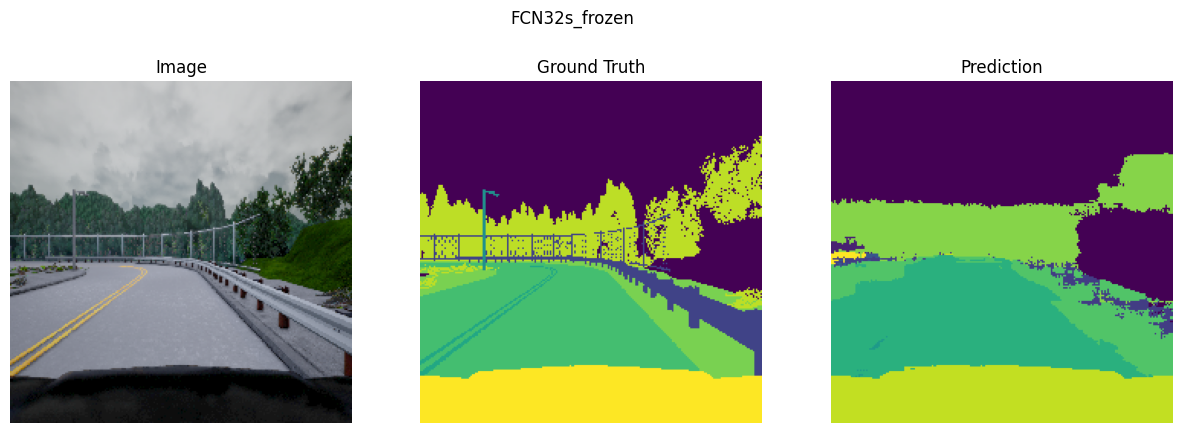

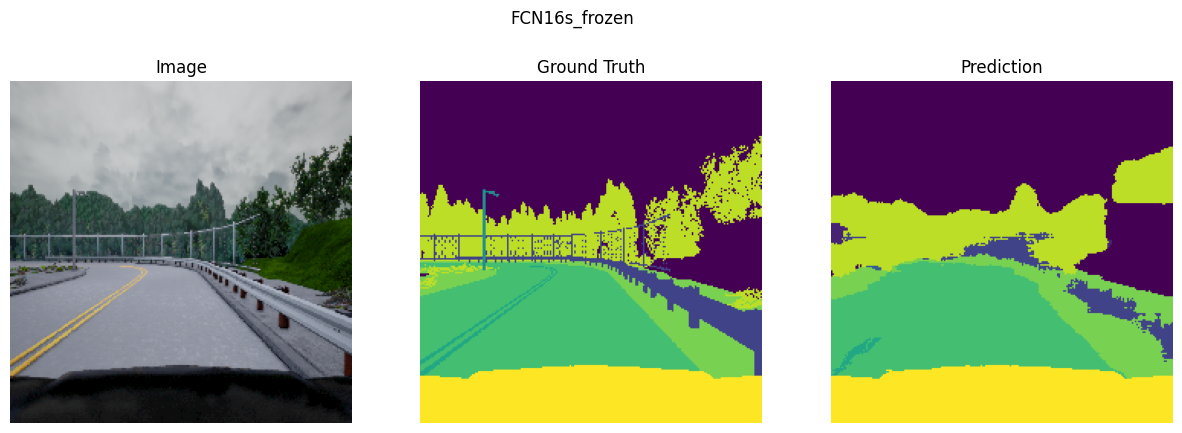

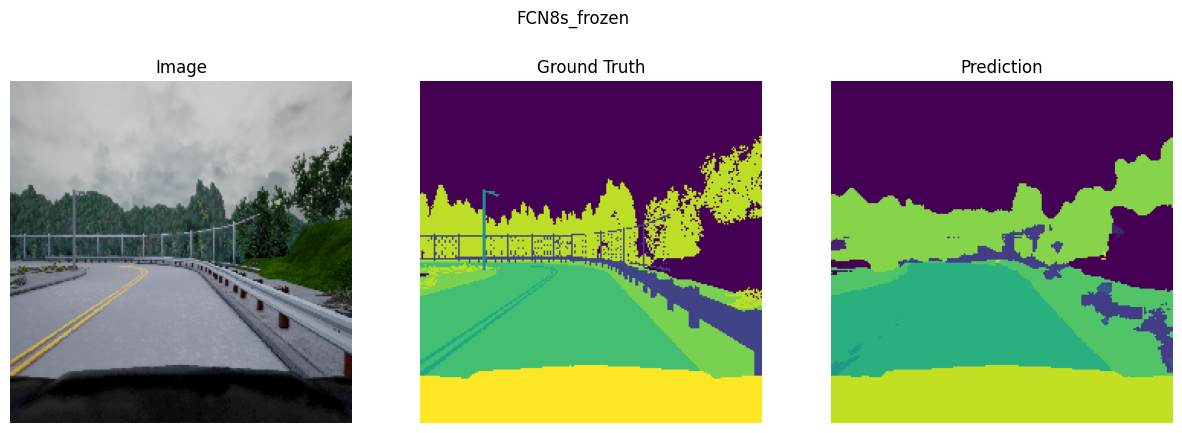

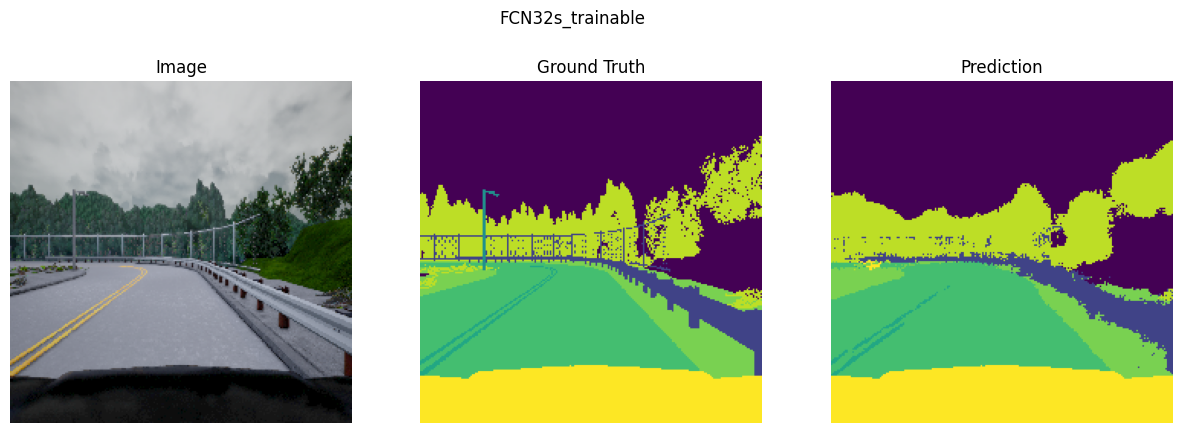

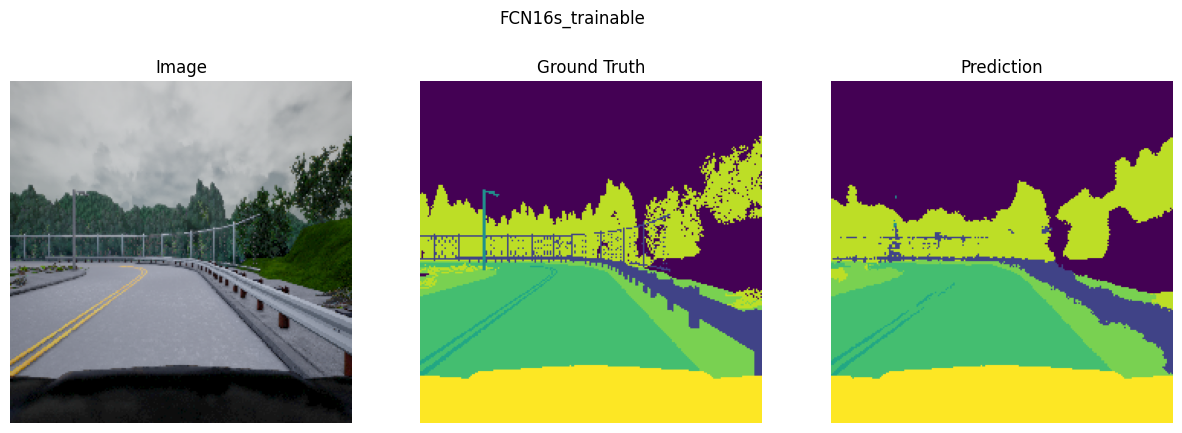

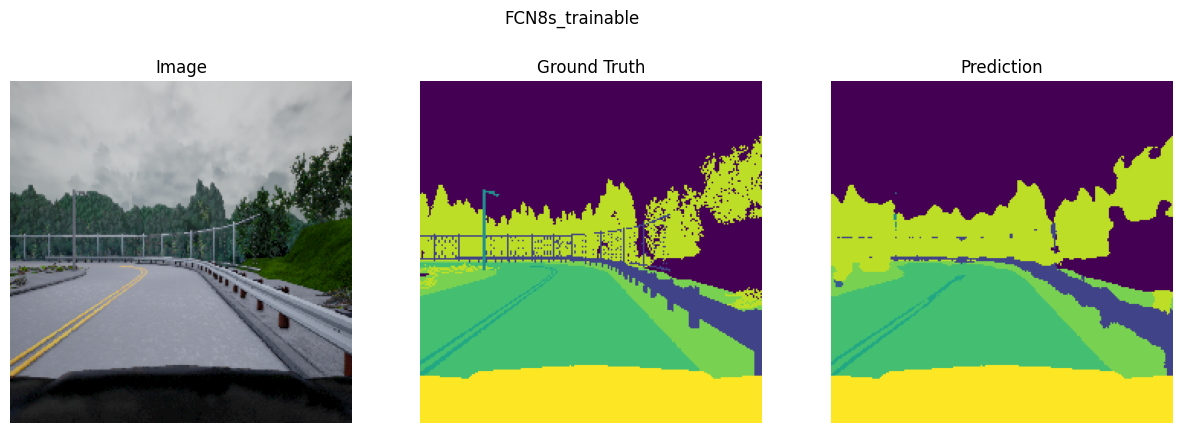

In [24]:
for name, model in fcn_models.items():
    show_predictions(model, val_loader, name)

#### Differences between the models

FCNs are a type of neural network architecture that is specifically designed for semantic segmentation tasks. They are built on the idea of using convolutional layers to process images and produce pixel-wise predictions. 
- FCN-32s: This is the simplest version of FCN, where the final layer is a 1x1 convolutional layer that reduces the number of channels to the number of classes. The output is then upsampled to the original image size using a deconvolutional layer. This model is fast but may not capture fine details in the segmentation.
- FCN-16s: This version improves upon FCN-32s by adding skip connections from earlier layers in the network. These skip connections allow the model to retain more spatial information and produce more accurate segmentations. The output is obtained by combining the upsampled output of FCN-32s with the features from an earlier layer.
- FCN-8s: This is the most complex version of FCN, which adds even more skip connections from earlier layers. The output is obtained by combining the upsampled output of FCN-16s with features from an even earlier layer. This model is capable of producing very detailed segmentations but is also more computationally expensive.
  
#### Frozen weights vs Trainable weights

VGG16 is a popular convolutional neural network architecture that has been widely used for image classification tasks. In the context of semantic segmentation, VGG16 can be used as a feature extractor, where the weights of the network are either frozen or trainable.
- Frozen weights: When the weights of VGG16 are frozen, the model uses the pre-trained weights from the original VGG16 model. This means that the model will not update the weights during training, and it will rely on the learned features from the pre-trained model. This approach is often used when there is limited training data available, as it allows the model to leverage the knowledge learned from a larger dataset.
- Trainable weights: When the weights of VGG16 are trainable, the model will update the weights during training. This allows the model to learn more specific features that are relevant to the semantic segmentation task at hand. This approach is often used when there is a large amount of training data available, as it allows the model to learn more complex features.

#### Results

Validation set:
| Model            | Loss   | IoU    |
|------------------|--------|--------|
| FCN32s_frozen    | 0.4023 | 0.6781 |
| FCN16s_frozen    | 0.2873 | 0.7486 |
| FCN8s_frozen     | 0.2427 | 0.7835 |
| FCN32s_trainable | 0.1824 | 0.7921 |
| FCN16s_trainable | 0.1407 | 0.8230 |
| FCN8s_trainable  | 0.1234 | 0.8427 |

Test set:
| Model            | Loss   | IoU    |
|------------------|--------|--------|
| FCN32s_frozen    | 0.3970 | 0.6776 |
| FCN16s_frozen    | 0.2849 | 0.7476 |
| FCN8s_frozen     | 0.2402 | 0.7818 |
| FCN32s_trainable | 0.1822 | 0.7875 |
| FCN16s_trainable | 0.1416 | 0.8199 |
| FCN8s_trainable  | 0.1250 | 0.8385 |

- The results show that the FCN8s model with trainable weights achieved the best performance on both the validation and test sets, with the lowest loss and highest IoU scores. This indicates that the model was able to learn more complex features and produce more accurate segmentations.
- The FCN8s model performed better than the FCN16s and FCN32s models, which is expected as it has more skip connections and can capture more spatial information.
